# 1. Motivation and Introduction

Social media content with a "personal angle"—that is, containing elements of personal vulnerabil- ity and/or storytelling—often garners more engagement due to their authentic, authoritative, and attention-grabbing nature. To aid my personal branding endeavors, I want to build a classifier that:
- Uncovers the patterns that distinguishes a personal post from a non-personal one
- Effectively uses those patterns to classify a piece of text (e.g. my LinkedIn post) as personal/non-personal, so that I can tweak it for higher engagement

To obtain the data, I conveniently sampled 28 LinkedIn mid-sized creators (3,000 - 20,000 followers) from my LinkedIn feed. Then, I wrote a custom Python script to visit each profile, randomly sample 15 posts without replacement, and scrape each post’s text, engagement count, and comment count.

This should yield 28 × 15 = 420 posts, but slight formatting differences on the LinkedIn website caused some posts to be scraped multiple times. After removing these duplicates, 416 unique posts remained, which the scraper saved into a CSV file.

Uploading this CSV file to Google Sheets, I manually labelled each of the 416 posts as "personal" or "non-personal", depending on whether the post contained a "personal angle" as defined above. I then exported this labelled dataset to CSV for the classifier to use.


# 2. Data Import and Conversion

To begin working on the dataset, we will import the data from the CSV using the pandas library:

In [1]:
# Import necessary libraries
import pandas as pd

# Import the data into a pandas DataFrame
df = pd.read_csv("./labelled_posts.csv")
df.head(), df.shape

(                                             content  engagement  comments  \
 0  Sending an email newsletter is a lot like dati...          13         5   
 1  It is a great week to connect with people who ...          18         0   
 2  Here's an effective strategy for designing you...         282         5   
 3  There are 4 elements of selling and scaling an...           4         1   
 4  One of the biggest changes I’ve made this year...          56         2   
 
    personal_exp  
 0         False  
 1         False  
 2         False  
 3         False  
 4          True  ,
 (416, 4))

# 3. Basic Data Cleaning and Pre-Processing

Since the dataset is relatively clean, only two pre-processing tasks remain:

**1. Removing Reposts.** LinkedIn users can share others’ posts as their own, also known as a "repost". While the original post might have a personal angle, it is not the reposter’s personal angle, so I will remove reposts. Engagement and comment counts are always zero for reposts, so I can remove all posts with this criteria— leaving us with 381 posts.

**2. Counting Words.** Most people assume that personal posts use more words, because these posts—especially those with storytelling attributes—need sufficient contextual and character devel- opment to do well. To check this assumption, I will counts the number of words in the column content, save that in a new column, word_count, and visualize its quartiles (Figure 1). The range of word counts for both post types are similar, so word count is not a very reliable feature to distinguish between the post types.

I will not be doing text pre-processing now as my text vectorizer will help me with it later. Addi- tionally, some common text pre-processing techniques like stemming (reducing words to their word stems) and removing stopwords (commonly occuring words) can dilute the contextual features of a personal post.

For example, pre-processing **"I gained 10,000 subscribers in 2 months. Here’s how I did it:" could give "Gained 10,000 subscribers 2 months. Here’s did:"** which lacks context on who gained those subscribers.

In [2]:
# Drop reposts (i.e. engagement == 0 && comments == 0)
no_reposts_df = df[(df['engagement'] != 0) | (df['comments'] != 0)].copy()

# Get word counts (useful for tokenization later)
no_reposts_df["word_count"] = no_reposts_df["content"].str.split().str.len()

# 381 posts, 4 columns
no_reposts_df.shape

(381, 5)

/Users/kyurikotpq/miniconda3/envs/ML_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/kyurikotpq/miniconda3/envs/ML_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/kyurikotpq/miniconda3/envs/ML_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


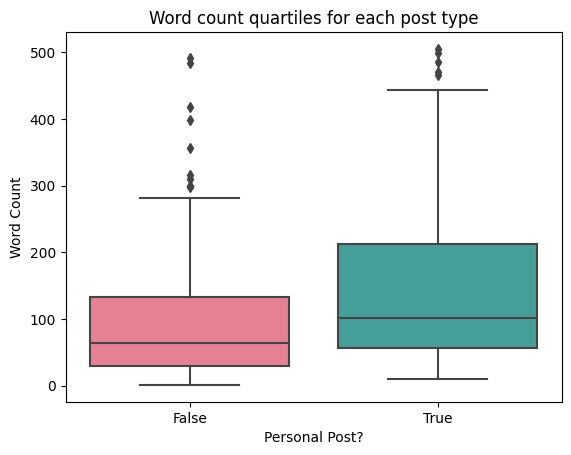

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the word count quartiles for each post type
sns.boxplot(data=no_reposts_df, x="personal_exp",
            y="word_count", palette="husl")

# #dataviz best practices
plt.xlabel("Personal Post?")
plt.ylabel("Word Count")
plt.title("Word count quartiles for each post type")
plt.show()


**Figure 1.** A boxplot showing the word count quartiles for each post type. While the Q1, median, and Q3 word count of personal posts are indeed higher than those of non-personal posts, the range of word counts for both post types are similar. This similarity undermines the usefulness of word counts as a distinguishing feature between the post types.

---

# 4. Train-Test Split

As aforementioned, I will perform **binary classification** ("personal" or "non-personal") on the data. Let’s begin by splitting the cleaned data into training and test data sets:


In [4]:
from sklearn.model_selection import train_test_split

# Separate content from "personal" labels
inputs, targets = no_reposts_df["content"], no_reposts_df["personal_exp"]

# Split into training and test datasets
X_train, X_test, y_train, y_test = train_test_split(inputs, targets, test_size=0.2, random_state=21)

# 5. Model Selection

**1. Choice of Text Representation.** To perform text classification, I need to represent the text numerically so that the machine can understand it. Two common approaches include **word embeddings** and **frequency-based techniques**. Word embeddings consider the words’ meanings before projecting them in multi-dimensional space; frequency-based techniques count the number of occurrences and, in techniques like term frequency–inverse document frequency (TF-IDF), assign weights (importance) to words based on their frequency in the document.
As such, in a frequency-based approach, similar sentences like *"The quick dog jumps over the lazy brown fox"* and *"The quick brown fox jumps over the lazy dog"* will have the same numeric rep- resentation, even though they are semantically different. This is not desirable for the classifier as the differences between personal and non-personal posts are often semantic, not frequency-based. Thus, I will use word embeddings to represent the textual data.

**2. Choice of Model.** Semantics are borne from complex, *nonlinear* relationships among words, which simpler classification models like logistic regression or Naive Bayes might struggle to model due to their use of linear decision boundaries. Neural networks might be better at modelling such non-linear relationships, thanks to their multilayered architecture and activation functions. Their structure also enables them to perform better at handling high-dimensional and unstructured data, which are inherent characteristics that our textual data has. Thus, given the importance of semantics for our classification, I will use a **neural network** model for the classifier.

**3. Mathematical Underpinnings.**

![Neural Network Diagram](nnetwork-diagram.png)

**Figure 2.** A diagram of the proposed neural network architecture. There is 1 Embedding layer to turn our word embeddings into dense vectors of a (tunable) fixed size; 1 Flatten layer to flatten these vectors into a 1D array, so that they can be fed to subsequent layers; 1 - 3 Dense layer(s), each with a tunable number of units, as hidden layers; 1 Dense layer with only one unit as the output layer. Since we are doing binary classification, this single unit uses the sigmoid activation function.

**3.1. Activation functions at the unit level.**
For the units in our hidden layers, we will use the **ReLU** activation function:
$$ ReLU(x) = max(0, x) $$

In other words, if the ReLU function receives a negative input $x$—the weighted sum of the previous layer (+ any bias)—it will return 0. Otherwise, it will return $x$.

Hence, since the gradient of ReLU is either 1 or 0 depending on the value of $x$, our gradient will either get backpropagated or not. 
1. **Main Advantage:** This helps us our model converge faster while avoiding the "vanishing gradient" problem found in other activation functions like sigmoid and tanh: The gradient decreases prematurely as the number of layers increases, so it cannot be effectively backpropagated to help the model adjust its weights.
2. **Main Disadvantage:** The all-or-nothing nature of the max() function means that a neuron can get "trapped" in the negative side, always giving an output of 0. In this scenario, the neuron becomes inactive and useless in the network, while continuing to consume memory and computational resources.

Despite the mentioned disadvantage, the simplicity of the ReLU function makes it more computationally efficient than other types of activation functions. Hence, we will use it for our hidden layers.

Finally, we will use the **sigmoid** activation function for the sole unit in the output layer. The sigmoid function maps $x$, the weighted sum of the last hidden layer (+ any bias), to a value in the range [0, 1]. This constriction suits the binary nature of our classification problem well. 
$$ S(x) = \frac{1}{1 + e^{-x}} $$

We can easily interpret the output of the sigmoid activation function as *the probability of an input belonging to the positive class*—in our case, the value of $P(personal)$.

**3.2. Backpropagation using Stochastic Gradient Descent (SGD).**

Backpropagation using SGD is a technique to iteratively adjust the weights of a neural network. The process can be broken down as follows:
1. Begin with a (randomized) set of weights and biases
2. Obtain predicted outputs during forward propagation
3. Calculate the average error (loss) between the predicted outputs and the actual labels using binary cross-entropy, L = $-\frac{1}{N} \sum_{i = 1}^{N} y_i \cdot log(p_i) + (1 - y_i) \cdot log(1 - p_i)$.
    1. $y_i$ (and $1 - y_i$) is the positive (and negative) label, respectively. In this case, the positive class is the "personal" label and has a value of 1, while the negative class has a value of 0.
    2. $log(p_i)$ (and $log(1 - p_i)$) is the predicted probability of the data point $i$ belonging to the positive (and negative) class 
    3. Thus, $y_i \cdot log(p_i) + (1 - y_i) \cdot log(1 - p_i)$ will evaluate to 0 for a 100\% accurate classification of one data point.
    4. Repeat the loss calculation for all $N$ data points and take the average.

    Hence, we use BCE instead of other loss functions like mean squared error because BCE's logarithmic nature better  encourages the model to output higher probabilities for the positive class (personal) and lower probabilities for the negative class (non-personal).

4. Backpropagate this loss. In doing so, we will now have a set of losses—one for each weight in the current layer.

    1. Applying SGD, we will randomly divide the set of losses into batches. For each batch, we will compute the gradient of each loss with respect to its weights by applying the chain rule of calculus: $gradient, \frac{\partial L}{\partial w} =  \frac{\partial L}{\partial y} \cdot \frac{\partial y}{\partial z} \cdot \frac{\partial z}{\partial w}$
    
    -  $\frac{\partial L}{\partial y}$: The derivative of the loss, $L$, with respect to the output $y$
    -  $\frac{\partial y}{\partial z}$: The derivative of the output $y$, with respect to the weighted sum of the inputs, $z = \sum_{i} w_ix_i$, for all connected weights
    -  $\frac{\partial z}{\partial w}$: The derivative of the the weighted sum of the inputs with respect to the weights, $w$
    
    2. Use the gradients to update the weights and biases with a certain learning rate (in this case, an arbitrary 0.1): 
    $$
        w_{new} = w_{old} - 0.1 \cdot gradient \\
        bias_{new} = bias_{old} - 0.1 \cdot gradient
    $$

These interactions at and between the various levels give rise to the classification capabilities of our neural network.

**4. Choice of ROC-AUC as Metric.** Accuracy measures the proportion of correctly classified instances. However, if there are significantly more samples of one class than the other, the model would not be good at classifying samples from the smaller class. Since there is a possibility of such class imbalances in future datasets—most posts are non-personal—accuracy might not be a very suitable metric.

Instead, I will use the ROC-AUC score. This score quantifies the model’s ability to discriminate between the two classes across different probability thresholds, regardless of class imbalances or not. Optimizing the ROC-AUC score, including during hyperparameter tuning, would thus help me build a more generalizable model.

---

Since I would like to tune:
- The output dimension of the embedding layer
- The number of hidden layers
- The number of units in each hidden layer

I will be creating a "hypermodel" so that Keras Tuner can search for the most optimal hyperparameters. The actual model will be created later in Section 7.

In [5]:
from tensorflow.keras import layers, Sequential, optimizers, metrics

# @TODO comment
MAX_FEATURES = no_reposts_df["word_count"].max()
SEQUENCE_LENGTH = int(0.01 * MAX_FEATURES)
MAX_EPOCHS = 50


def create_hypermodel(hp):
    # Create a Sequential model for a neural network
    model = Sequential()

    # Define a hyperparameter search space using Keras Tuner
    HP_OUTPUT_DIM = hp.Int('output_dim', min_value=16,
                           max_value=80, step=16)

    # Add an Embedding layer with a dynamic output dimension based on the hyperparameter
    model.add(layers.Embedding(MAX_FEATURES + 1,
              HP_OUTPUT_DIM, input_length=SEQUENCE_LENGTH))

    # Add a Flatten layer to convert the embedded features into a 1D array
    model.add(layers.Flatten())

    # Add multiple dense layers with hyperparameter tuning
    for i in range(hp.Int("num_layers", 1, 3)):
        model.add(
            layers.Dense(
                # Tune number of units separately.
                units=hp.Int(f"units_{i}", min_value=16,
                             max_value=128, step=16),
                activation="relu"
            )
        )

    # Add a final Dense layer with a single unit and
    # sigmoid activation for binary classification
    # (personal/not personal)
    model.add(layers.Dense(1, activation='sigmoid'))

    # Compile the model with:
    # - binary cross-entropy loss
    # - SGD optimizer
    # - accuracy metric
    model.compile(loss="binary_crossentropy",
                  optimizer=optimizers.legacy.SGD(
                      learning_rate=0.1),
                  metrics=[metrics.AUC(name="auc")])

    return model


# 6. Model Training

In this section, I performed hyperparameter tuning with Bayesian optimization. The models with different hyperparameters are trained and evaluated across multiple folds, a technique known as K-Fold Cross-Validation.

**Why BayesianOptimization?** Instead of trying a random combination of hyperparameters each time—a common problem in the RandomSearch and Hyperband algorithms—the tuner chooses the first few combinations randomly, then uses the performance from these hyperparameters to *inform* its subsequent choices of hyperparameters. Hence, BayesianOptimization is potentially more efficient and fruitful in its search, thanks to its consideration of the historical performance of attempted hyperparameters to choose the best possible hyperparameters next.

**Why TextVectorization?** Apart from generating word embeddings, TextVectorization also helps with preprocessing:
1. Standardize each sample (usually lowercasing + punctuation stripping)
2. Split each sample into substrings (usually words)
3. Recombine substrings into tokens (usually ngrams)
4. Index tokens (associate a unique int value with each token)
5. Transform each sample using this index, either into a vector of ints or a dense float vector.

This makes it easy for me to transform my textual data into their numerical representations so that they can be fed into subsequent layers.

In [6]:
import numpy as np
import keras_tuner as kt
from tensorflow.keras import layers
from sklearn.model_selection import KFold


def model_eval(inputs, targets):
    # Initialize the BayesianOptimization tuner
    # for hyperparameter search based on Area Under Curve
    tuner = kt.BayesianOptimization(create_hypermodel,
                                    objective=kt.Objective(
                                        'val_auc', direction='max'),
                                    directory="archive",
                                    project_name="bayes",
                                    overwrite=True
                                    )

    # K-fold Cross Validation fold counter
    fold_no = 1

    # Define per-fold score containers
    loss_per_fold = []
    auc_per_fold = []

    # Initialize K-fold cross-validation with 5 splits
    kfolder = KFold(n_splits=5, shuffle=True, random_state=42)

    # Go through each fold
    for train, val in kfolder.split(inputs, targets):
        # Learn the vocabulary of the training data
        # using TextVectorization
        vectorizer = layers.TextVectorization(
            max_tokens=MAX_FEATURES,
            output_mode='int',
            output_sequence_length=SEQUENCE_LENGTH)
        vectorizer.adapt(inputs[train])

        # Vectorize the training data
        X_train = vectorizer(inputs[train])
        y_train = targets[train]

        # Perform hyperparameter search with Keras Tuner
        tuner.search(X_train, y_train,
                     validation_split=0.2, verbose=False)

        # Get the optimal hyperparameters
        best_hps = tuner.get_best_hyperparameters()[0]

        # Build the model with the optimal hyperparameters and train it
        model = tuner.hypermodel.build(best_hps)
        history = model.fit(
            X_train, y_train, epochs=MAX_EPOCHS, validation_split=0.2, verbose=False)

        # Find the best epoch based on validation AUC
        val_acc_per_epoch = history.history['val_auc']
        best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1

        # Retrain the model on the best hyperparameters and epoch
        hypermodel = tuner.hypermodel.build(best_hps)
        hypermodel.fit(X_train, y_train, epochs=best_epoch,
                       validation_split=0.2, verbose=False)

        # Vectorize the validation data
        X_val = vectorizer(inputs[val])
        y_val = targets[val]

        # Evaluate the model on the validation data
        scores = hypermodel.evaluate(
            X_val, y_val, verbose=False)

        loss_per_fold.append(scores[0])
        auc_per_fold.append(scores[1])

        # Increase fold number
        fold_no = fold_no + 1

    # Return the best hyperparameters and their
    # corresponding AUC and loss metrics
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    hp_data = {
        "loss": round(np.mean(loss_per_fold), 3),
        "AUC": round(np.mean(auc_per_fold), 3),
        'output_dim': best_hps.values['output_dim'],
        'num_layers': best_hps.values['num_layers'],
    }

    # Capture the best model's structure
    total_params = best_hps.values['output_dim']

    # Track the sequence of layer(s)
    # and their no. of units
    units = []

    # Track the last layer's unit
    last_units = 0

    # Iterate over a maximum of three Dense
    # layers (units_0, units_1, units_2)
    for i in range(best_hps.values['num_layers']):
        num_units = 0

        try:
            # If the Dense layer exists, track the
            # no. of units in the layer
            if best_hps.values[f"units_{i}"]:
                num_units = best_hps.values[f"units_{i}"]

                # Save the number of units per
                # layer in the correct sequence
                units.append(str(num_units))

                total_params += num_units
                last_units = num_units
        except:
            pass

    # Store in hp_data for return
    hp_data["units"] = units

    total_params += last_units + 1
    hp_data["total_params"] = total_params

    return hp_data


Using TensorFlow backend


Since there is some degree of randomness to all Keras Tuners, I repeated the exploration 10 times and collected the results for further analysis and model selection.

In [7]:
def find_best_model(tries, X_train, y_train):
    # Track metric & hyperparameter
    # information about the neural networks
    data = []

    for _ in range(tries):
        # Find and save the best neural network structure
        data.append(model_eval(X_train, y_train))

    # Print a table summarizing the neural networks' structures
    print("Loss\t", "AUC\t", "Embedding Dim.\t",
          "No. of Layers\t", "Total Params\t", "Hidden Layers\t")

    for hp_data in data:
        print(f"{hp_data['loss']}\t",
              f"{hp_data['AUC']}\t",
              f"{hp_data['output_dim']}\t\t",
              f"{hp_data['num_layers']}\t\t",
              f"{hp_data['total_params']}\t\t",
              f"{' → '.join(hp_data['units'])}\t",
              )


In [8]:
# Try to find the best neural network structure, 10 times
find_best_model(10, X_train.copy().to_numpy(), y_train.copy().to_numpy())


Loss	 AUC	 Embedding Dim.	 No. of Layers	 Total Params	 Hidden Layers	
0.607	 0.72	 64		 3		 449		 128 → 64 → 96	
0.654	 0.726	 64		 3		 289		 32 → 32 → 80	
0.577	 0.723	 16		 1		 273		 128	
0.589	 0.654	 32		 2		 145		 80 → 16	
0.704	 0.726	 80		 3		 401		 128 → 32 → 80	
0.573	 0.679	 80		 1		 177		 48	
0.689	 0.708	 80		 2		 177		 64 → 16	
0.743	 0.651	 80		 3		 241		 112 → 16 → 16	
0.593	 0.672	 64		 2		 193		 96 → 16	
0.583	 0.713	 80		 1		 337		 128	


# 7. Predicting Labels & Performance Evaluation

From the table above, we were able to obtain the lowest loss and one of the best AUC scores in the second and third row. Both of them only used one hidden layer, but the number of units in this hidden layer differed, based the output dimension of the embedding layer.

We will pick the model that is more resource-efficient—the model with the smaller total number of parameters. This is the one in the second row, with an output dimension of 32 for the Embedding layer, and 48 units for the sole hidden layer.

Then, we will:
1. Build a new neural network model with these optimal hyperparameters
2. Create a new vectorizer and build a vocabulary from our training dataset
3. Vectorize our training dataset with the new vectorizer, and feed it to our model for training
4. Evaluate ROC-AUC and Accuracy scores using our test dataset

In [22]:
from sklearn.metrics import roc_auc_score, accuracy_score

def create_model(output_dim, num_layers, units):
    # Create a Sequential model for a neural network
    best_model = Sequential()

    # Add an Embedding layer with a dynamic output dimension based on the hyperparameter
    best_model.add(layers.Embedding(MAX_FEATURES + 1,
                                    output_dim, input_length=SEQUENCE_LENGTH))

    # Add a Flatten layer to convert the embedded features into a 1D array
    best_model.add(layers.Flatten())

    # Add multiple dense layers with hyperparameter tuning
    for i in range(num_layers):
        best_model.add(
            layers.Dense(
                # Tune number of units separately.
                units=units[i],
                activation="relu"
            )
        )

    # Add a final Dense layer with a single unit and
    # sigmoid activation for binary classification
    # (personal/not personal)
    best_model.add(layers.Dense(1, activation='sigmoid'))

    # Compile the model with:
    # - binary cross-entropy loss
    # - SGD optimizer
    # - accuracy metric
    best_model.compile(loss="binary_crossentropy",
                       optimizer=optimizers.legacy.SGD(
                           learning_rate=0.1),
                       metrics=[metrics.AUC(name="auc")])
    
    return best_model

# Create a fresh vectorizer with
# a vocabulary based on our training data
vectorizer = layers.TextVectorization(
    max_tokens=MAX_FEATURES,
    output_mode='int',
    output_sequence_length=SEQUENCE_LENGTH)
vectorizer.adapt(X_train)

# Vectorize the training data
X_train_vectorized = vectorizer(X_train)

# Re-create the model from the best hyperparameters
OUTPUT_DIM = 32
NUM_LAYERS = 1
UNITS = [48]
best_model = create_model(OUTPUT_DIM, NUM_LAYERS, UNITS)

# Train the model
best_model.fit(X_train_vectorized, y_train, epochs=MAX_EPOCHS, verbose=False)

# Evaluate the best model on the test set
y_pred = best_model.predict(vectorizer(X_test))
nn_roc_auc = roc_auc_score(y_test, y_pred)

converted_y_pred = list(map(lambda x: x > 0.5, y_pred))
nn_accuracy = accuracy_score(y_test, converted_y_pred)

# Report the ROC-AUC score on the test set
print("ROC-AUC Score on Test Set:", nn_roc_auc)

# Report the accuracy on the test set
print("Accuracy Score on Test Set:", nn_accuracy)


3/3 [==============================] - 0s 1ms/step
ROC-AUC Score on Test Set: 0.8099838969404186
Accuracy Score on Test Set: 0.7532467532467533


# 8. Result Visualization & Discussion
From the print statements and Figure 3, we see that our model has a ROC-AUC score of around 0.8, reflecting an 80% probability that the model will rank a randomly chosen positive instance higher than a randomly chosen negative instance. This means that, 80% of the time, the y_pred for a randomly chosen personal post will be higher than the y_pred for a randomly chosen non-personal post—a relatively good performance at discriminating between the two classes.

Meanwhile, our accuracy score of around 0.75 means that the model accurately classifies whether a post is personal or non-personal for 75% of the test dataset. The disparity between the two scores could be due to class imbalances, where one class significantly outnumbers the other, which is picked up by the accuracy metric thanks to its tendency to be biased toward the dominant class.

Accounting for both metrics, it seems that our model has a relatively good performance—it should be able to classify a post as "personal" or "non-personal" most of the time.

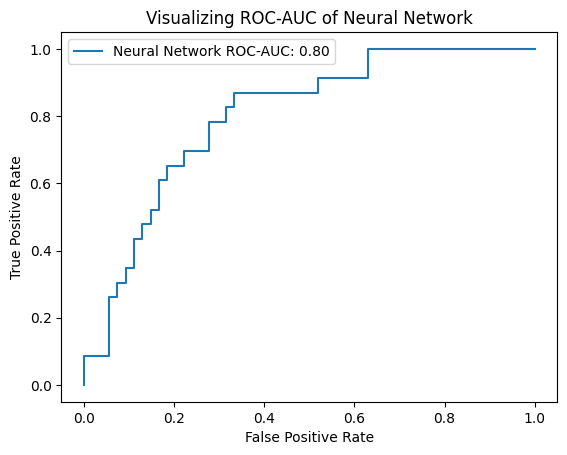

In [16]:
from sklearn.metrics import roc_curve

# Obtain the ROC curve for plotting
nn_curve = roc_curve(y_test, y_pred)

# Plot the curve with #dataviz best practices
plt.plot(nn_curve[0], nn_curve[1], label="Neural Network ROC-AUC: %.2f" % nn_roc_auc)
plt.title("Visualizing ROC-AUC of Neural Network")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

**Figure 3.** A line plot showing the ROC-AUC curve for our model. While not perfect, our curve is convex, meaning that it has more predictive power than a completely random model (which would have a ROC-AUC "curve" equivalent to a diagonal line).

# 9. Executive Summary

**Summary of Pipeline.** In this assignment, I tried to build a classifier that distinguishes between a post with a personal angle and a post without a personal angle.

After cleaning the data, I made several choices to account for the non-linear complexities of our textual data data. First, I chose to represent our data with word embeddings instead of a frequency-based approach, as the former better accounts for the semantics of a word in its given context. Next, I decided on a neural network model instead of simpler models like logistic regression or Naive Bayes as the architecture of neural networks can the model non-linear relationships better.

Then, using K-fold Cross Validation and Keras Tuner, I tried to find the most optimal hyperparameters for the network structure. A simple network with only one 48-unit hidden layer was one of the better-performing ones, so I selected it as my final model and ran ROC-AUC and accuracy metrics to test its performance.
Based on the results above, I was able to train a neural network that classifies a post as personal or non-personal with a high degree of accuracy. The good ROC-AUC score also means that the model should be generalizable to unseen datasets of posts.

**Areas for Improvement.**

- A higher quality data sample could potentially improve the model. The sample size of 381 is small relative to most classifiers used in the industry. Additionally, since the posts were sampled from only 28 people, it is possible that the people are in similar niches, and the model might have picked up on niche-specific linguistic features in the text—not the linguistic features of a personal post.
- Training other models, especially those with non-linear decision boundaries (like Support Vector Machines), would have provided a better basis of comparison about the superiority (or inferiority) of our model’s performance.
- Consent from the post authors is being obtained as of writing, but it should be completed before the entire assignment was started.


# 10. References
- Team, K. (2023). Keras documentation: Classification metrics based on True/False positives & negatives. Keras.io. https://keras.io/api/metrics/classification_metrics/#auc-class
- Team, K. (2023). Keras documentation: Embedding layer. Keras.io. https://keras.io/api/layers/core_layers/embedding/
- Team, K. (2019). Keras documentation: Getting started with KerasTuner. Keras.io. https://keras.io/guides/keras_tuner/getting_started/#builtin-metric-as-the-ob jective
- Team, K. (2023). Keras documentation: TextVectorization layer. Keras.io. https://keras.io/api/layers/preprocessing_layers/core_preprocessing_layers/text_vectorization/ ‌
- Wadekar, S. (2021, January 10). Hyperparameter Tuning in Keras: TensorFlow 2: With Keras Tuner: RandomSearch, Hyperband, BayesianOptimization. Medium; The Startup. https://medium.com/swlh/hyperparameter-tuning-in-keras-tensorflow-2-with- keras-tuner-randomsearch-hyperband-3e212647778f
- GitHub Link (including dataset): https://github.com/kyurikotpq/linkedin- ml/tree/main/classification